<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95087 entries, 0 to 95086
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   acdnt_year             95087 non-null  int64  
 1   occrrnc_time_code      95087 non-null  int64  
 2   legaldong_name         95087 non-null  object 
 3   acdnt_hdc              95087 non-null  object 
 4   lrg_violt_1_dc         95087 non-null  object 
 5   road_stle_dc           95087 non-null  object 
 6   wrngdo_vhcle_asort_dc  95087 non-null  object 
 7   acdnt_age_1_code       95087 non-null  int64  
 8   rdse_sttus_dc          95087 non-null  object 
 9   road_div               83421 non-null  float64
 10  lat                    95087 non-null  float64
 11  lng                    95087 non-null  float64
 12  near_crosswalk         95087 non-null  int64  
 13  near_traffic_light     95087 non-null  int64  
 14  near_child_zone        95087 non-null  int64  
 15  ne

/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_25178/2317103406.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


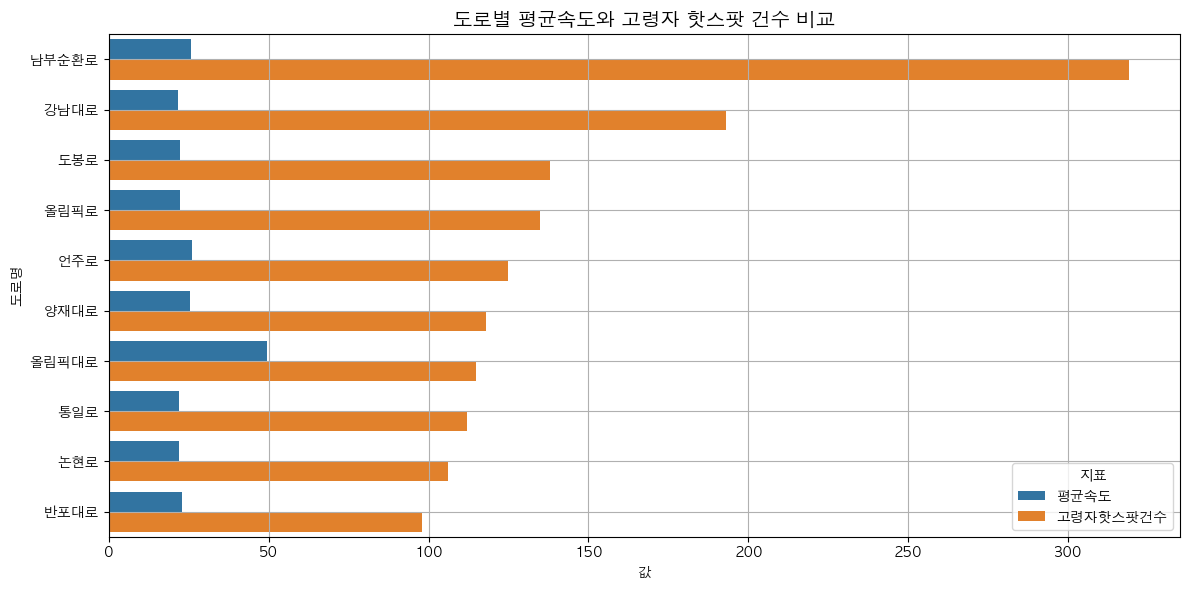

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
 # 한글 폰트 설정 (Mac 기준)
plt.rc('font', family='AppleGothic')  # 한글 깨짐 방지용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
import seaborn as sns
# CSV 불러오기
file_path = "/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/data/processed/accident_data_filtered.csv"
df = pd.read_csv(file_path)

# route_nm별 평균 속도 계산
speed_by_route = (
    df.dropna(subset=["route_nm", "velocity"])
      .groupby("route_nm")["velocity"]
      .mean()
      .reset_index()
      .rename(columns={"velocity": "평균속도"})
      .sort_values("평균속도", ascending=False)
)
df.info()
# route_nm별 평균 속도 및 고령자 핫스팟 수 계산
hotspot_speed_by_route = (
    df.dropna(subset=["route_nm", "velocity", "elderly_hotspot"])
      .groupby("route_nm")
      .agg(
          평균속도=("velocity", "mean"),
          고령자핫스팟건수=("elderly_hotspot", "sum")
      )
      .reset_index()
      .sort_values("고령자핫스팟건수", ascending=False)
)
hotspot_speed_by_route.info()

print(hotspot_speed_by_route.head(20))  # 상위 20개 출력

# 시각화: 도로별 평균속도와 고령자 핫스팟 건수 비교
compare_df = hotspot_speed_by_route.head(10)
compare_melted = compare_df.melt(id_vars="route_nm", value_vars=["평균속도", "고령자핫스팟건수"],
                                  var_name="지표", value_name="값")

plt.figure(figsize=(12, 6))
sns.barplot(data=compare_melted, x="값", y="route_nm", hue="지표")
plt.title("도로별 평균속도와 고령자 핫스팟 건수 비교", fontsize=14)
plt.xlabel("값")
plt.ylabel("도로명")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()



In [3]:
from scipy.stats import pearsonr

# 속도 & 고령자 사고건수 데이터
x = hotspot_speed_by_route['평균속도']
y = hotspot_speed_by_route['고령자핫스팟건수']

# 상관계수 계산
corr, p_value = pearsonr(x, y)
print(f"상관계수: {corr:.3f}, p-value: {p_value:.4f}")

상관계수: 0.182, p-value: 0.0001


통계적으로유의하지만, 약한 상관계수를 띈다. 속도와 고령자 사고건수 

In [5]:
import statsmodels.api as sm

X = hotspot_speed_by_route[['평균속도']]
X = sm.add_constant(X)
y = hotspot_speed_by_route['고령자핫스팟건수']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               고령자핫스팟건수   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     15.88
Date:                Tue, 20 May 2025   Prob (F-statistic):           7.85e-05
Time:                        23:40:18   Log-Likelihood:                -2197.9
No. Observations:                 466   AIC:                             4400.
Df Residuals:                     464   BIC:                             4408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3406      4.510     -0.076      0.9

      route_nm          평균교통량  고령자핫스팟건수  사고건수
418      남부순환로   69228.556834     319.0  2186
2229   일반국도6호선   65648.199379     399.0  2113
2009     올림픽대로  103943.373626     115.0  1756
2224   일반국도3호선   78697.427344     249.0  1517
2227  일반국도47호선  105130.453928     183.0  1221
75        강변북로  110058.417000      40.0  1026
54        강남대로   94128.908436     193.0   972
2226  일반국도46호선   64484.549528     147.0   849
757     동부간선도로   84740.614980      51.0   815
1825       언주로   81612.979301     125.0   791
1766      양재대로  111431.442270     118.0   738
2536       통일로   56818.669540     112.0   714
645        도봉로   49005.810127     138.0   707
2228  일반국도48호선   58952.244300     117.0   660
502        논현로   77606.524257     106.0   639
2010      올림픽로   63500.707741     135.0   634
2222   일반국도1호선   59867.449735      69.0   617
2507      테헤란로   61539.244207      97.0   561
2647       한천로   70624.402697      69.0   528
455     내부순환도로   63855.477407      47.0   521


/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_25178/3786065885.py:10: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_25178/3786065885.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


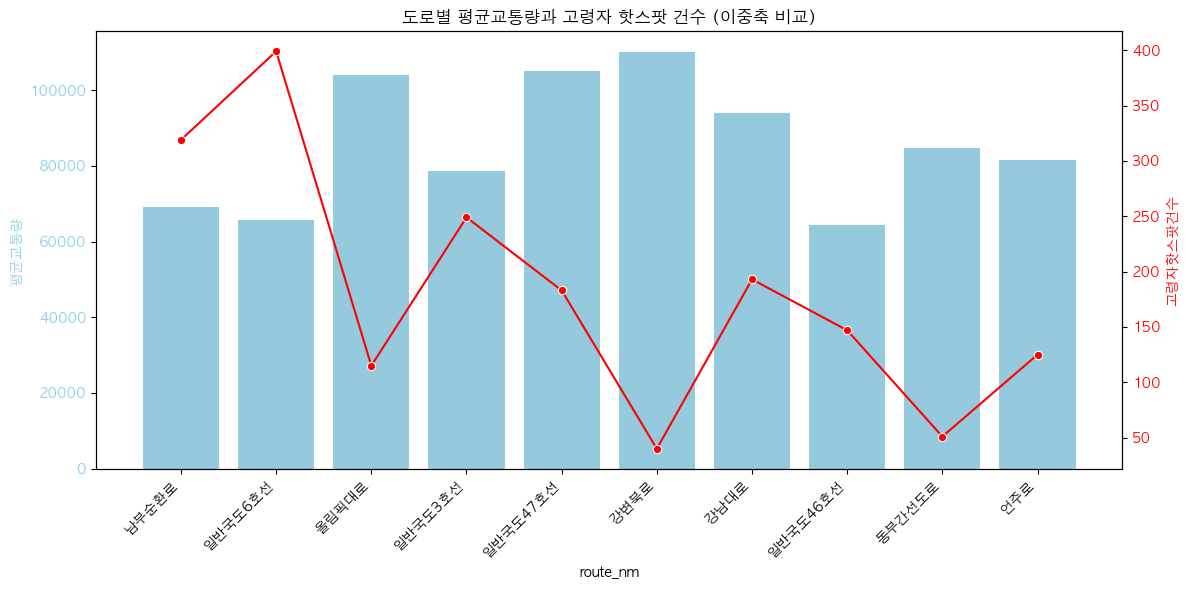

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
# 한글 폰트 설정 (Mac 기준)
plt.rc('font', family='AppleGothic')  # 한글 깨짐 방지용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
import seaborn as sns

# CSV 파일 불러오기
file_path = "/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/data/processed/accident_data_filtered.csv"
df = pd.read_csv(file_path)
df['traffic_volume'] = pd.to_numeric(df['traffic_volume'], errors='coerce')

# route_nm별 사고건수 포함
accident_by_route = (
    df.dropna(subset=["route_nm"])
      .groupby("route_nm")
      .agg(
          평균교통량=("traffic_volume", "mean"),
          고령자핫스팟건수=("elderly_hotspot", "sum"),
          사고건수=("route_nm", "count")
      )
      .reset_index()
      .sort_values("사고건수", ascending=False)
)

print(accident_by_route.head(20))  # 상위 20개 출력

fig, ax1 = plt.subplots(figsize=(12, 6))

compare_df = accident_by_route.head(10)

# 첫 번째 축: 평균 교통량 막대그래프
sns.barplot(data=compare_df, x="route_nm", y="평균교통량", ax=ax1, color='skyblue')
ax1.set_ylabel("평균교통량", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# 두 번째 축: 고령자핫스팟건수 선그래프
ax2 = ax1.twinx()
sns.lineplot(data=compare_df, x="route_nm", y="고령자핫스팟건수", ax=ax2, color='red', marker='o')
ax2.set_ylabel("고령자핫스팟건수", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("도로별 평균교통량과 고령자 핫스팟 건수 (이중축 비교)")
plt.tight_layout()
plt.show()

In [10]:
accident_by_route.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2771 entries, 418 to 583
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   route_nm  2771 non-null   object 
 1   평균교통량     2658 non-null   float64
 2   고령자핫스팟건수  2771 non-null   float64
 3   사고건수      2771 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 108.2+ KB


In [12]:
from scipy.stats import pearsonr

# 속도 & 고령자 사고건수 데이터
x = accident_by_route['평균교통량']
y = accident_by_route['고령자핫스팟건수']

# 상관계수 계산
corr, p_value = pearsonr(x, y)
print(f"상관계수: {corr:.3f}, p-value: {p_value:.4f}")

상관계수: nan, p-value: nan


In [ ]:
import statsmodels.api as smㅇ
# NaN 제거
filtered = accident_by_route[["평균교통량", "고령자핫스팟건수"]].dropna()

# 상관계수 계산
from scipy.stats import pearsonr
corr, p_value = pearsonr(filtered["평균교통량"], filtered["고령자핫스팟건수"])
print(f"상관계수: {corr:.3f}, p-value: {p_value:.4f}")
X = accident_by_route[['평균교통량']]
X = sm.add_constant(X)
y = accident_by_route['고령자핫스팟건수']

model = sm.OLS(y, X).fit()
print(model.summary())

상관계수: 0.012, p-value: 0.5336


MissingDataError: exog contains inf or nans